Keras implementation of combined Conditional VAE and Auxiliary-Classifier GAN.

* The combined VAE-GAN is partially inspired from the paper "Autoencoding beyond pixels using a learned similarity metric" with major modifications.

* Keras tricks to train GAN is ispired from https://github.com/keras-team/keras/issues/8585 and https://github.com/eriklindernoren/Keras-GAN

# Environment Setup

## Modules

In [1]:
# imports
### Disable tensorflow 2.0
%tensorflow_version 1.x
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()

from __future__ import print_function, division
from builtins import range, input
import numpy as np
import matplotlib.pyplot as plt
from pdb import set_trace
import keras
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, Lambda, Activation, Dropout, Reshape, Add, Multiply, MaxPooling2D, AveragePooling2D, concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.losses import mse, binary_crossentropy, categorical_crossentropy
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import plot_model
from keras import backend as K
## added to plot model in google colab
from IPython.display import Image

TensorFlow 1.x selected.


Using TensorFlow backend.


In [2]:
import os
from datetime import datetime

import imageio

In [3]:
import sys
sys.path

['/tensorflow-1.15.2/python3.7',
 '',
 '/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython']

In [4]:
root = "/drive/MyDrive/FHNW/galaxy_generator/"
root_output = root + "output_keras/"
# append path if needed
sys.path.append(root)

## Parameters

In [5]:
# Encoder parameters
img_dim = 64
colors = 3
labels_dim = 3
latent_dim = 8
dec_dim = latent_dim # default equals to latent_dim. (different in case PCA is applied before decoder, not used here)
filter_size = 3

In [6]:
# General parameters
ALPHA = 1 # to switch from VAE (1) to AE (0)
BETA = 1 # for beta-VAE (weight for KL). Default is 1
ZETA = 1/2 # for combined GAN VAE with MSE loss (weight for MSE)
DELTA = 1 # for the auxiliary classifier at the output of GAN
GAMMA = 1 #1024 # for learned metric (https://arxiv.org/pdf/1512.09300.pdf)
optimizer = Adam(0.0002, 0.5) #RMSprop()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


# Useful functions

In [7]:
## plot network
def summarize(network):
    # summary of the encoder
    network.summary()
    # plot model
    plot_model(network, to_file='network.png', show_shapes=True, show_layer_names=True)
    display(Image(retina=True, filename='network.png'))



# Networks

## Discriminator

### Discriminator 1

In [8]:
# GAN Discriminator 1
input_disc = Input(shape=(img_dim,img_dim,colors,), name="disc_input")
h_disc = Conv2D(filters= 8, kernel_size=3, strides=2, padding='same', activation="relu", name="disc_conv_1_activated")(input_disc)
h_disc = Conv2D(filters= 16, kernel_size=3, strides=2, padding='same', name="disc_conv_2_no-activation")(h_disc)
h_disc = BatchNormalization(name="disc_batchNorm_1")(h_disc)
h_disc = Activation(activation="relu", name="disc_relu_1")(h_disc)
## new
h_disc = Conv2D(filters= 32, kernel_size=3, strides=2, padding='same', activation="relu", name="disc_conv_3_activated")(h_disc)
h_disc = Conv2D(filters= 64, kernel_size=3, strides=2, padding='same', activation="relu", name="disc_conv_4_activated")(h_disc)
#h = Conv2D(filters= 2*latent_dim, kernel_size=4, strides=1, padding='valid', name="enc_conv_5_no-activation")(h) # exactly equivalent to FC
f_disc = Flatten(name="disc_flatten")(h_disc)
## additional dense layer for dimensionality reduction
d_disc = Dense(256, activation ="relu", name="disc_dense_1_mean_activated")(f_disc)
##
out_disc = Dense(1, activation="sigmoid", name="disc_dense_2_std_activated")(d_disc)
##

#f = Flatten(name="enc_flatten")(h)
#d = Dense(100,name="enc_dense_1_no-activation")(f)
#d = BatchNormalization(name="enc_batchNorm_2")(d)
#d = Activation(activation="relu", name="enc_relu_2")(d)
#z_mu = Dense(latent_dim,name="enc_dense_2_mean_no-activation")(d)
#z_std = Dense(latent_dim, activation="softplus", name="enc_dense_2_std_activated")(d)

## new
#z_mu = Lambda(lambda x : x[:,:latent_dim], name="enc_split_1")(f)
#z_std = Lambda(lambda x : x[:,latent_dim:], name="enc_split_2")(f)
#z_std = Activation(activation="softplus", name="enc_sofplus")(z_std)
##

discriminator_1 = Model(inputs=input_disc, outputs=out_disc, name="discriminator")

### Discriminator 3

In [9]:
# GAN Discriminator 3
img = Input(shape=(img_dim,img_dim,colors,), name="D_in")
# Conv from image
h = Conv2D(32, kernel_size=1, strides=1, padding="same")(img)
h = LeakyReLU(alpha=0.2)(h)
# Conv 1
h = Conv2D(64, kernel_size=5, strides=2, padding="same")(h)
h = BatchNormalization(momentum=0.99)(h)
h = LeakyReLU(alpha=0.2)(h)
# Conv 2
h = Conv2D(128, kernel_size=5, strides=2, padding="same")(h)
h = BatchNormalization(momentum=0.99)(h)
h = LeakyReLU(alpha=0.2)(h)
# Flatten
h = Flatten()(h)
# Dense 1
h = Dense(1024)(h)
h = BatchNormalization(momentum=0.99)(h)
h = LeakyReLU(alpha=0.2)(h)
# Dense 2
D_out = Dense(1, activation='sigmoid', name="D_out")(h)
        
discriminator_3 = Model(img,D_out,name="discriminator")

### Discriminator 4

In [10]:
# GAN Discriminator 4 (disriminator with auxiliary classifier and learned metric output)
img = Input(shape=(img_dim,img_dim,colors,), name="D_in_metric")
# Conv from image
h = Conv2D(16, kernel_size=1, strides=1, padding="same")(img)
h = LeakyReLU(alpha=0.2)(h)
# Conv 1
h = Conv2D(32, kernel_size = filter_size, strides=2, padding="same")(h)
h = BatchNormalization(momentum=0.99)(h)
h = LeakyReLU(alpha=0.2)(h)
# Conv 2
h = Conv2D(64, kernel_size = filter_size, strides=2, padding="same")(h)
h = BatchNormalization(momentum=0.99)(h)
h = LeakyReLU(alpha=0.2)(h)
# Conv 3
h = Conv2D(128, kernel_size = filter_size, strides=2, padding="same")(h)
h = BatchNormalization(momentum=0.99)(h)
h = LeakyReLU(alpha=0.2)(h)
# Flatten
h = Flatten()(h)
# Dense 1
h = Dense(1024)(h)
h = BatchNormalization(momentum=0.99)(h)
h_metric = LeakyReLU(alpha=0.2)(h)
discriminator_metric = Model(img,h_metric,name="discriminator_metric")


img_disc = Input(shape=(img_dim,img_dim,colors,), name="D_in")

##  features
metric_disc = discriminator_metric(img_disc)  

# Dense 2
## true/fake
D_out = Dense(1, activation='sigmoid', name="D_out_adv")(metric_disc)
## labels
D_out_labels = Dense(labels_dim, activation='softmax', name="D_out_labels")(metric_disc)
#discriminator_4 = Model(img,[D_out,D_out_labels],name="discriminator")
discriminator_4 = Model(img_disc,concatenate([D_out,D_out_labels,metric_disc]),name="discriminator")

### Summary

In [11]:
discriminator = discriminator_4

Model: "discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
D_in (InputLayer)               (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
discriminator_metric (Model)    (None, 1024)         8491680     D_in[0][0]                       
__________________________________________________________________________________________________
D_out_adv (Dense)               (None, 1)            1025        discriminator_metric[1][0]       
__________________________________________________________________________________________________
D_out_labels (Dense)            (None, 3)            3075        discriminator_metric[1][0]       
______________________________________________________________________________________

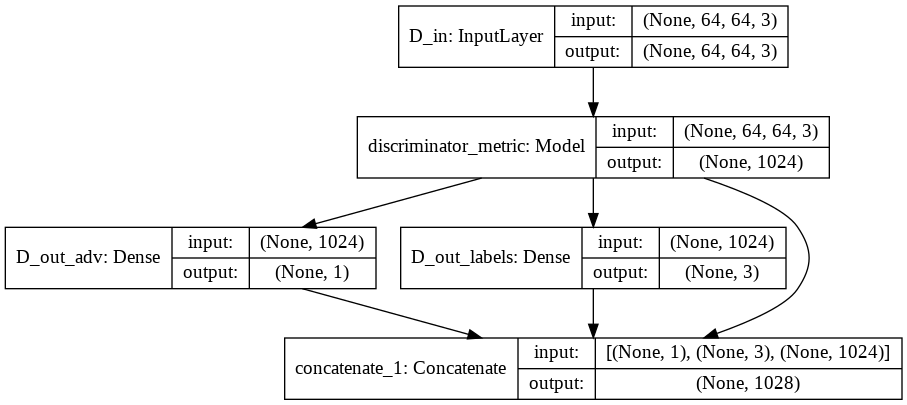

In [12]:
# summary of the discriminator
discriminator.summary()
# plot model
plot_model(discriminator, to_file='discriminator.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='discriminator.png')

## Encoder

### Encoder 1

In [13]:
# VAE encoder 1
input_enc = Input(shape=(img_dim,img_dim,colors,), name="enc_input")
h = Conv2D(filters= 8, kernel_size=3, strides=2, padding='same', activation="relu", name="enc_conv_1_activated")(input_enc)
h = Conv2D(filters= 16, kernel_size=3, strides=2, padding='same', name="enc_conv_2_no-activation")(h)
h = BatchNormalization(name="enc_batchNorm_1")(h)
h = Activation(activation="relu", name="enc_relu_1")(h)
## new
h = Conv2D(filters= 32, kernel_size=3, strides=2, padding='same', activation="relu", name="enc_conv_3_activated")(h)
h = Conv2D(filters= 64, kernel_size=3, strides=2, padding='same', activation="relu", name="enc_conv_4_activated")(h)
#h = Conv2D(filters= 2*latent_dim, kernel_size=4, strides=1, padding='valid', name="enc_conv_5_no-activation")(h) # exactly equivalent to FC
f = Flatten(name="enc_flatten")(h)
## additional dense layer for dimensionality reduction
d = Dense(256, activation ="relu", name="enc_dense_1_mean_activated")(f)
##
z_mu = Dense(latent_dim,name="enc_dense_2_mean_no-activation")(d)
if ALPHA:
  z_std = Dense(latent_dim, activation="softplus", name="enc_dense_2_std_activated")(d) #only for VAE
##

#f = Flatten(name="enc_flatten")(h)
#d = Dense(100,name="enc_dense_1_no-activation")(f)
#d = BatchNormalization(name="enc_batchNorm_2")(d)
#d = Activation(activation="relu", name="enc_relu_2")(d)
#z_mu = Dense(latent_dim,name="enc_dense_2_mean_no-activation")(d)
#z_std = Dense(latent_dim, activation="softplus", name="enc_dense_2_std_activated")(d)

## new
#z_mu = Lambda(lambda x : x[:,:latent_dim], name="enc_split_1")(f)
#z_std = Lambda(lambda x : x[:,latent_dim:], name="enc_split_2")(f)
#z_std = Activation(activation="softplus", name="enc_sofplus")(z_std)
##
if ALPHA:
  encoder_1 = Model(inputs=input_enc, outputs=[z_mu,z_std], name="encoder")
else:
  encoder_1 = Model(inputs=input_enc, outputs=z_mu, name="encoder")

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
enc_input (InputLayer)          (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
enc_conv_1_activated (Conv2D)   (None, 32, 32, 8)    224         enc_input[0][0]                  
__________________________________________________________________________________________________
enc_conv_2_no-activation (Conv2 (None, 16, 16, 16)   1168        enc_conv_1_activated[0][0]       
__________________________________________________________________________________________________
enc_batchNorm_1 (BatchNormaliza (None, 16, 16, 16)   64          enc_conv_2_no-activation[0][0]   
____________________________________________________________________________________________

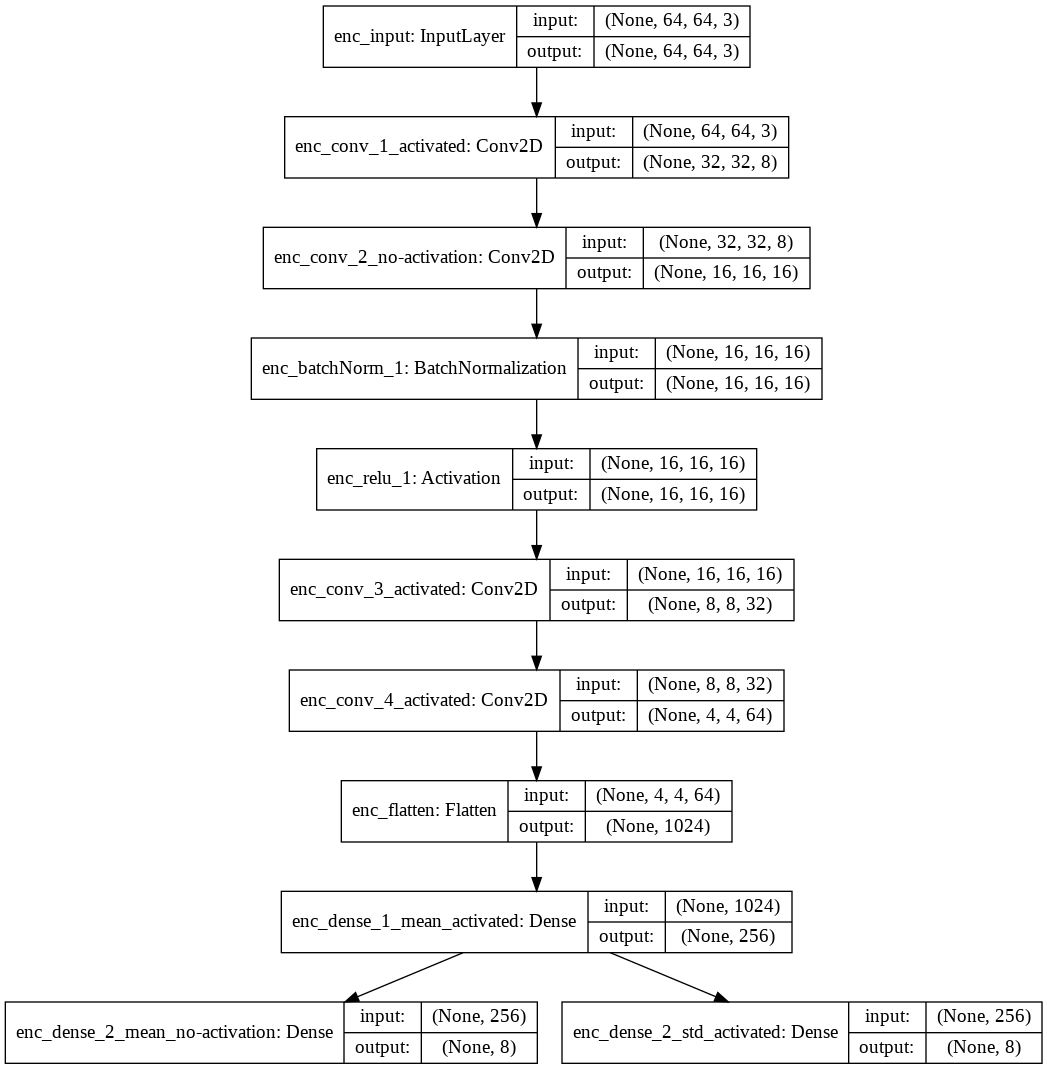

In [14]:
summarize(encoder_1)

### Encoder 2

In [15]:
# VAE encoder 2 - Inception units
input_enc = Input(shape=(img_dim,img_dim,colors,), name="enc_input")
## inception 1
inc1_1 = Conv2D(filters= 4, kernel_size=1, strides=1, padding='same', activation="relu")(input_enc)
inc1_2 = Conv2D(filters= 4, kernel_size=3, strides=1, padding='same', activation="relu")(input_enc)
h = concatenate([inc1_1,inc1_2])

h = Conv2D(filters= 8, kernel_size=3, strides=2, padding='same', activation="relu", name="enc_conv_1_activated")(h)

## inception 2
inc2_1 = Conv2D(filters= 8, kernel_size=1, strides=1, padding='same', activation="relu")(h)
inc2_2 = Conv2D(filters= 8, kernel_size=3, strides=1, padding='same', activation="relu")(h)
h = concatenate([inc2_1,inc2_2])

h = Conv2D(filters= 16, kernel_size=3, strides=2, padding='same', name="enc_conv_2_no-activation")(h)
h = BatchNormalization(name="enc_batchNorm_1")(h)
h = Activation(activation="relu", name="enc_relu_1")(h)

## inception 3
inc3_1 = Conv2D(filters= 16, kernel_size=1, strides=1, padding='same', activation="relu")(h)
inc3_2 = Conv2D(filters= 16, kernel_size=3, strides=1, padding='same', activation="relu")(h)
h = concatenate([inc3_1,inc3_2])

h = Conv2D(filters= 32, kernel_size=3, strides=2, padding='same', activation="relu", name="enc_conv_3_activated")(h)

## inception 4
inc4_1 = Conv2D(filters= 32, kernel_size=1, strides=1, padding='same', activation="relu")(h)
inc4_2 = Conv2D(filters= 32, kernel_size=3, strides=1, padding='same', activation="relu")(h)
h = concatenate([inc4_1,inc4_2])

h = Conv2D(filters= 64, kernel_size=3, strides=2, padding='same', activation="relu", name="enc_conv_4_activated")(h)

f = Flatten(name="enc_flatten")(h)
## additional dense layer for dimensionality reduction
d = Dense(256, activation ="relu", name="enc_dense_1_mean_activated")(f)
##
z_mu = Dense(latent_dim,name="enc_dense_2_mean_no-activation")(d)
if ALPHA:
  z_std = Dense(latent_dim, activation="softplus", name="enc_dense_2_std_activated")(d)

if ALPHA:
  encoder_2 = Model(inputs=input_enc, outputs=[z_mu,z_std], name="encoder")
else:
  encoder_2 = Model(inputs=input_enc, outputs=z_mu, name="encoder")

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
enc_input (InputLayer)          (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 64, 64, 4)    16          enc_input[0][0]                  
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 64, 64, 4)    112         enc_input[0][0]                  
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 64, 64, 8)    0           conv2d_8[0][0]                   
                                                                 conv2d_9[0][0]             

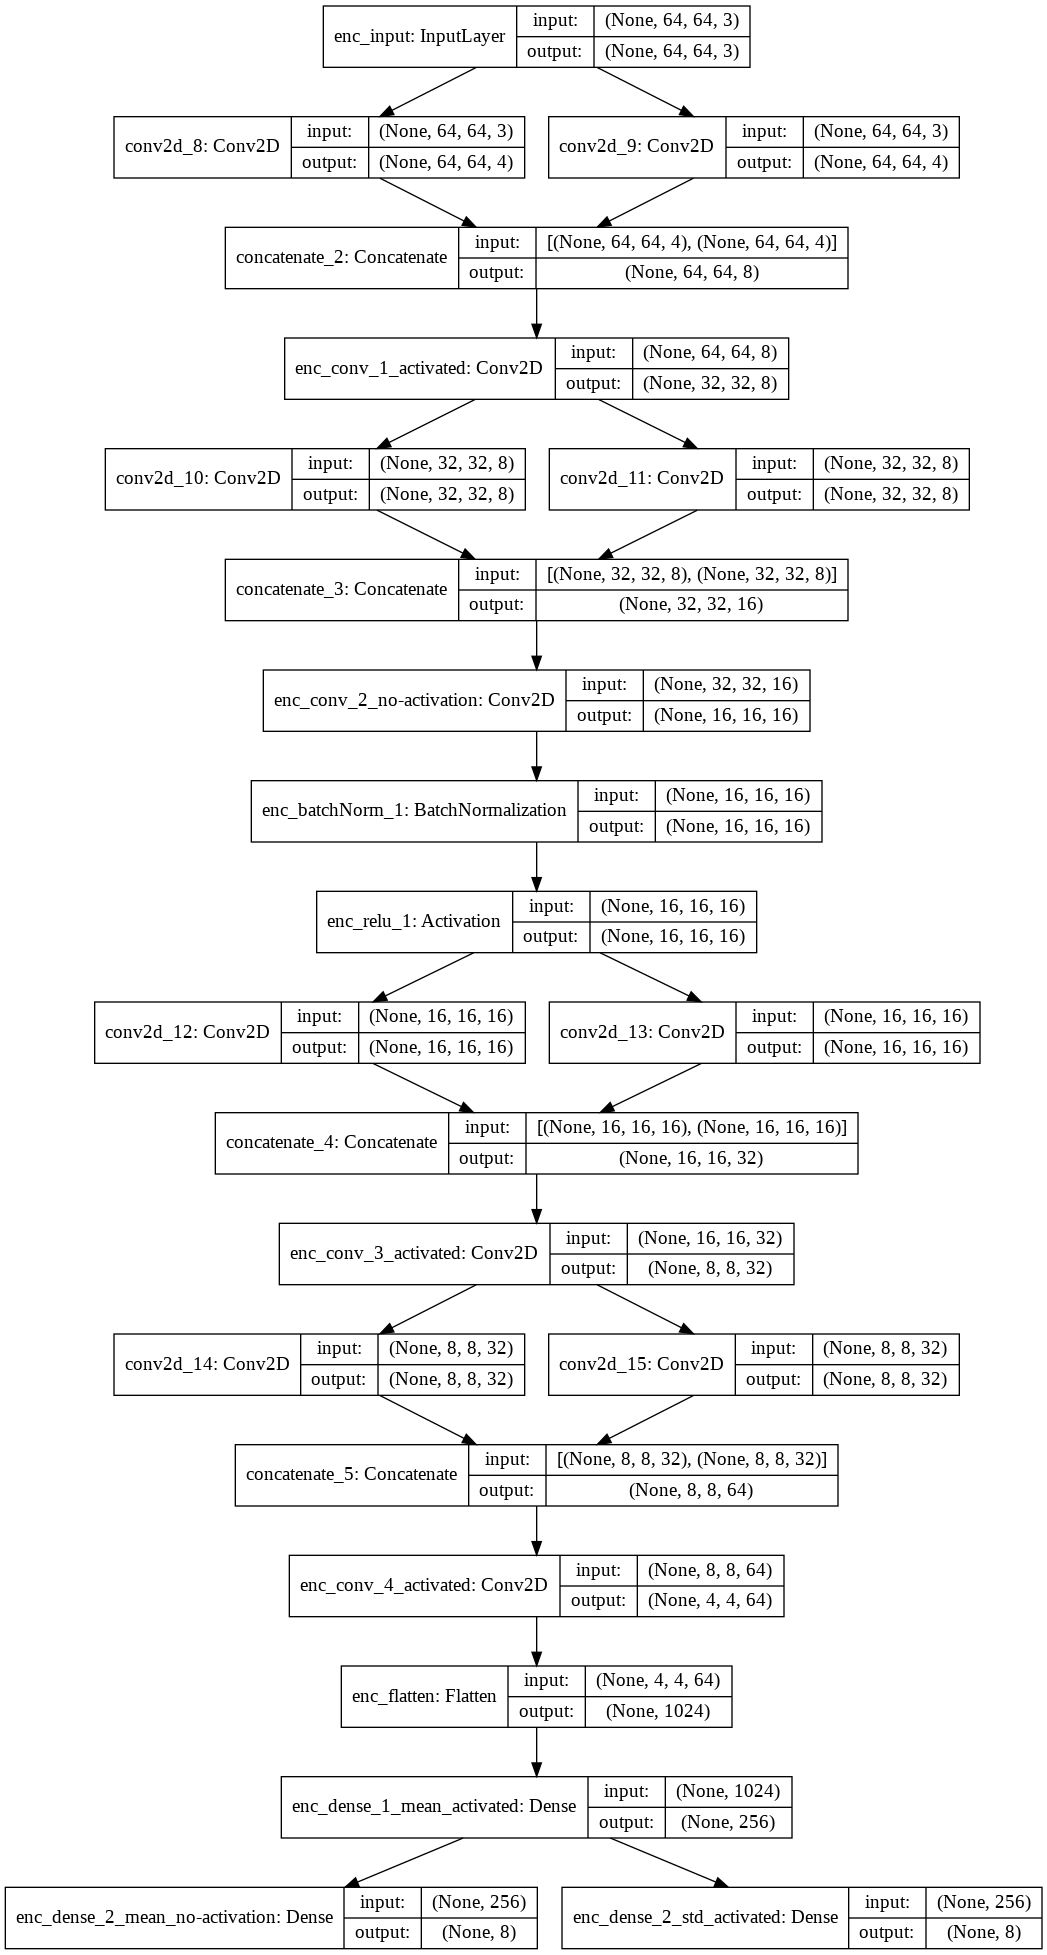

In [16]:
summarize(encoder_2)

### Encoder 3

In [17]:
# encoder 3
img = Input(shape=(img_dim,img_dim,colors,), name="enc_in")
# Conv from image
h = Conv2D(32, kernel_size=1, strides=1, padding="same")(img)
h = LeakyReLU(alpha=0.2)(h)
# Conv 1
h = Conv2D(64, kernel_size=5, strides=2, padding="same")(h)
h = BatchNormalization(momentum=0.99)(h)
h = LeakyReLU(alpha=0.2)(h)
# Conv 2
h = Conv2D(128, kernel_size=5, strides=2, padding="same")(h)
h = BatchNormalization(momentum=0.99)(h)
h = LeakyReLU(alpha=0.2)(h)
# Flatten
f = Flatten()(h)
# Dense 1
d = Dense(1024)(f)
d = BatchNormalization(momentum=0.99)(d)
d = LeakyReLU(alpha=0.2)(d)
# Dense 2
z_mu = Dense(latent_dim,name="enc_dense_2_mean_no-activation")(d)
if ALPHA:
  z_std = Dense(latent_dim, activation="softplus", name="enc_dense_2_std_activated")(d)

if ALPHA:
  encoder_3 = Model(inputs=img, outputs=[z_mu,z_std], name="encoder")
else:
  encoder_3 = Model(inputs=img, outputs=z_mu, name="encoder")

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
enc_in (InputLayer)             (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 64, 64, 32)   128         enc_in[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu_10 (LeakyReLU)      (None, 64, 64, 32)   0           conv2d_16[0][0]                  
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 32, 32, 64)   51264       leaky_re_lu_10[0][0]             
____________________________________________________________________________________________

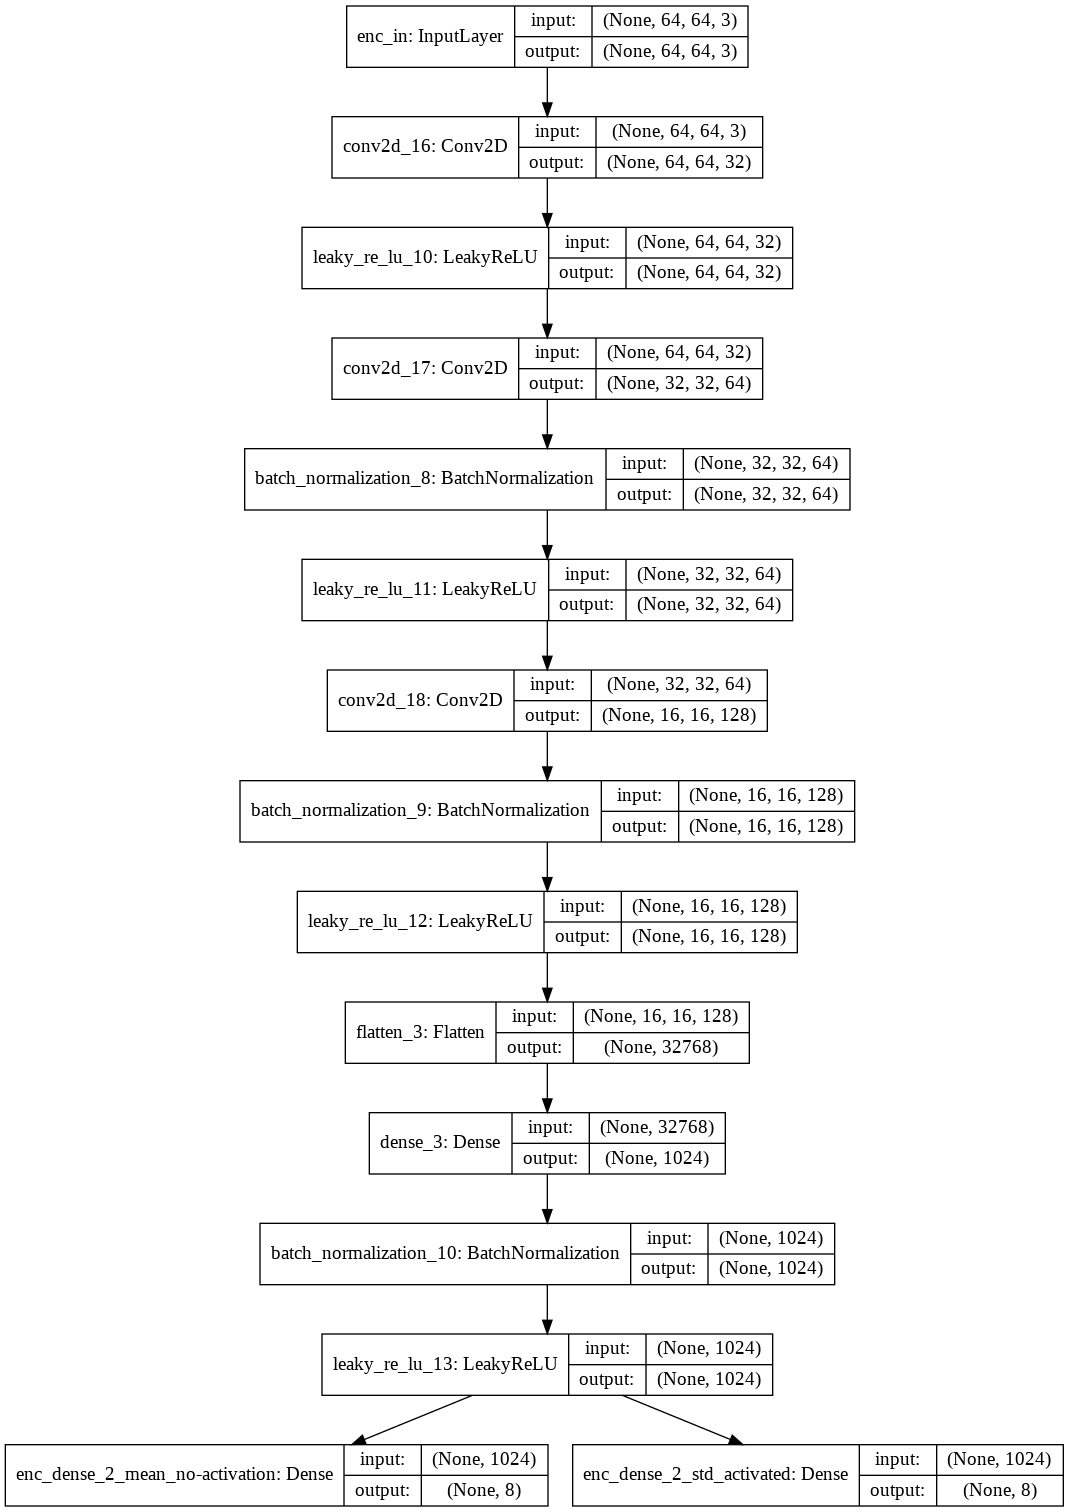

In [18]:
summarize(encoder_3)

### Encoder 4

In [19]:
# encoder 4
img = Input(shape=(img_dim,img_dim,colors,), name="enc_in")
input_enc_labels = Input(shape=(labels_dim,), name="enc_input_labels")
# Conv from image
h = Conv2D(16, kernel_size=1, strides=1, padding="same")(img)
h = LeakyReLU(alpha=0.2)(h)
# Conv 1
h = Conv2D(32, kernel_size=filter_size, strides=2, padding="same")(h)
h = BatchNormalization(momentum=0.99)(h)
h = LeakyReLU(alpha=0.2)(h)
# Conv 2
h = Conv2D(64, kernel_size=filter_size, strides=2, padding="same")(h)
h = BatchNormalization(momentum=0.99)(h)
h = LeakyReLU(alpha=0.2)(h)
# Conv 3
h = Conv2D(128, kernel_size=filter_size, strides=2, padding="same")(h)
h = BatchNormalization(momentum=0.99)(h)
h = LeakyReLU(alpha=0.2)(h)
# Flatten
f = Flatten()(h)
## add labels
f_c = concatenate([f,input_enc_labels])
# Dense 1
d = Dense(1024)(f_c)
d = BatchNormalization(momentum=0.99)(d)
d = LeakyReLU(alpha=0.2)(d)
# Dense 2
z_mu = Dense(latent_dim,name="enc_dense_2_mean_no-activation")(d)
if ALPHA:
  z_std = Dense(latent_dim, activation="softplus", name="enc_dense_2_std_activated")(d)

if ALPHA:
  encoder_4 = Model(inputs=[img,input_enc_labels], outputs=[z_mu,z_std], name="encoder")
else:
  encoder_4 = Model(inputs=[img,input_enc_labels], outputs=z_mu, name="encoder")

<

In [20]:
encoder = encoder_4

### Summary

In [21]:
# track the dimension before and after flattening
dim_pre_flatten = h._keras_shape[1:]
dim_post_flatten  = f._keras_shape[1]
print(dim_pre_flatten,dim_post_flatten)

(8, 8, 128) 8192


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
enc_in (InputLayer)             (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 64, 64, 16)   64          enc_in[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu_14 (LeakyReLU)      (None, 64, 64, 16)   0           conv2d_19[0][0]                  
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 32, 32, 32)   4640        leaky_re_lu_14[0][0]             
____________________________________________________________________________________________

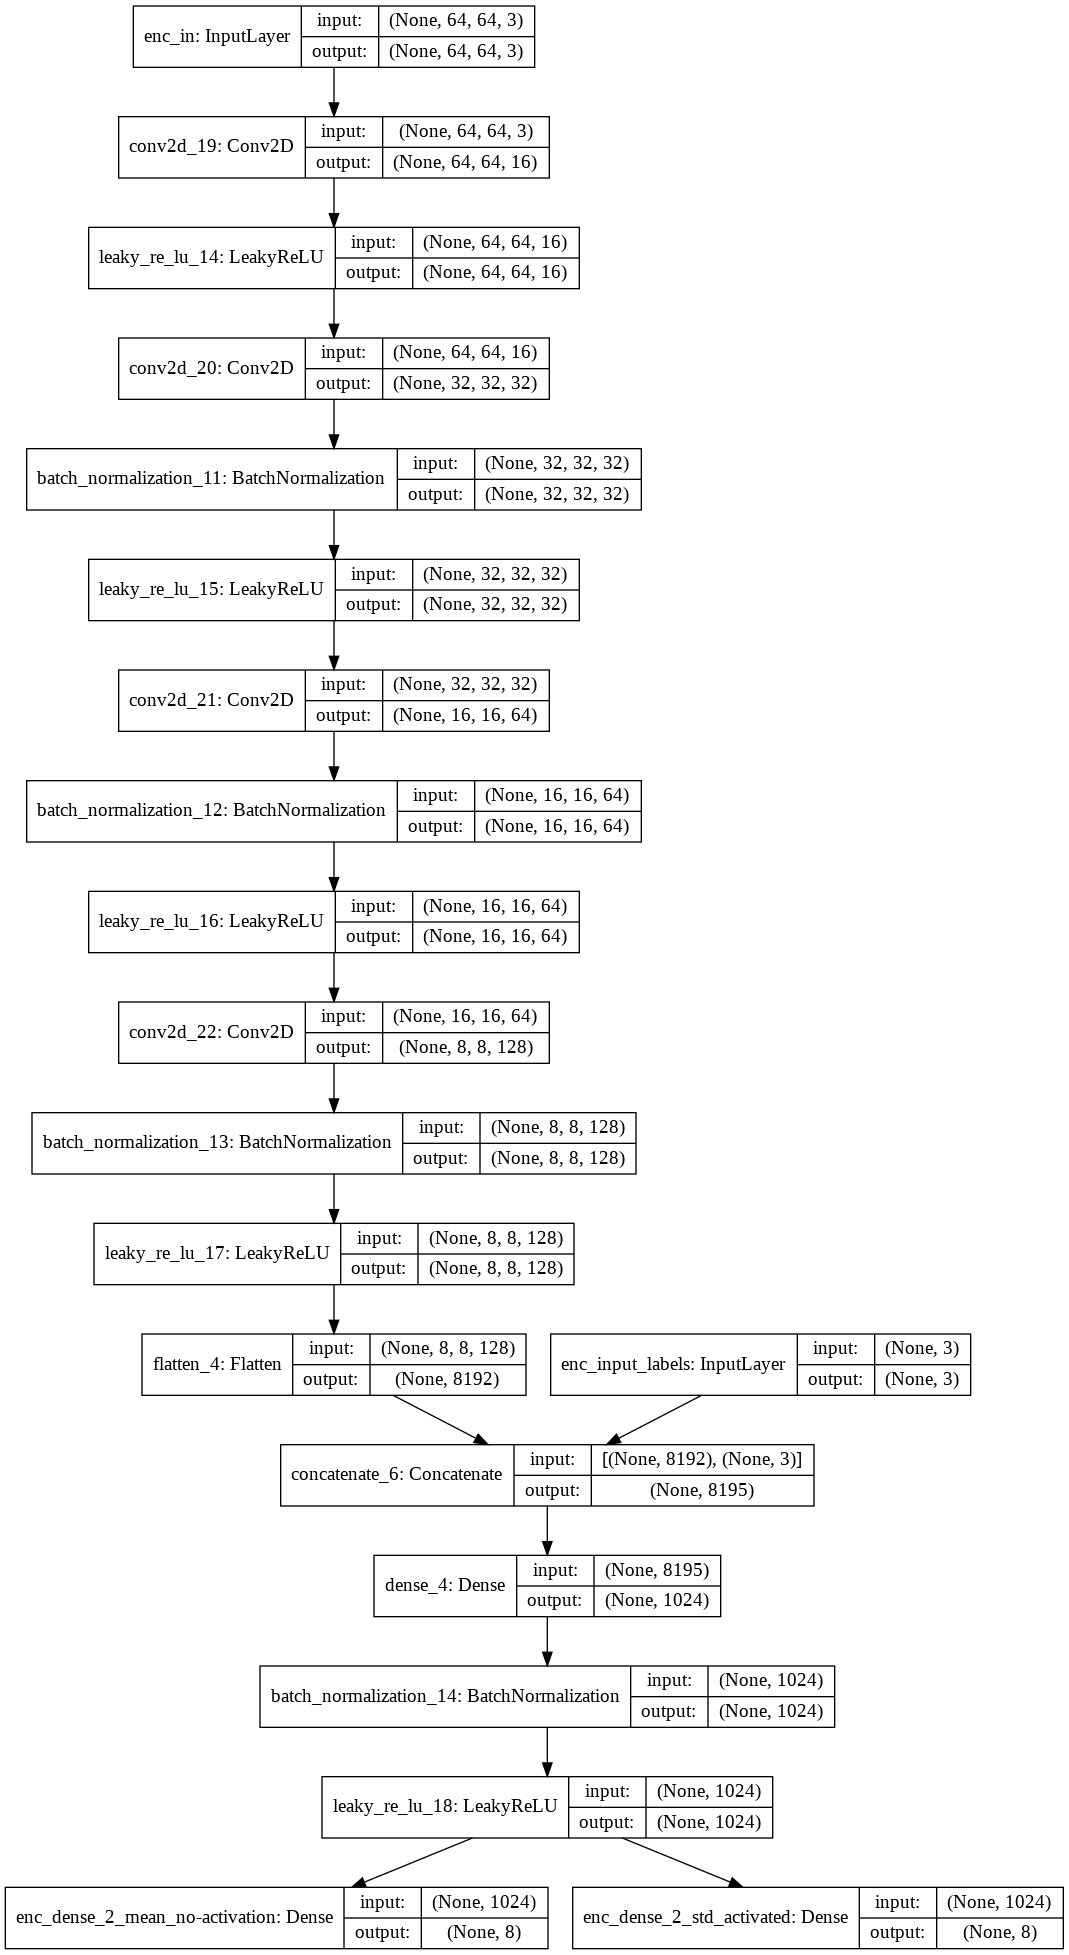

In [22]:
# summary of the encoder
encoder.summary()
# plot model
plot_model(encoder, to_file='encoder.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='encoder.png')

## Decoder

### Decoder 1

In [23]:
# VAE decoder 1
input_dec = Input(shape=(dec_dim,), name="dec_input")
#h_d = Dense(100, activation="relu", name="dec_dense_1_activated")(input_dec)
#h_d = Dense(dim_post_flatten, name="dec_dense_2_no-activation")(h_d)
#h_d = BatchNormalization(name="dec_batchNorm_1")(h_d)
#h_d = Activation(activation="relu", name="dec_relu_1")(h_d)
#h_d = Reshape(dim_pre_flatten,name="dec_reshape")(h_d)

##new
h_d = Dense(dim_post_flatten, name="dec_dense_2_no-activation")(input_dec)
h_d = BatchNormalization(name="dec_batchNorm_1")(h_d)
h_d = Activation(activation="relu", name="dec_relu_1")(h_d)
h_d = Reshape(dim_pre_flatten,name="dec_reshape")(h_d)
#h_d = Reshape((dim_pre_flatten[0],dim_pre_flatten[1],dim_pre_flatten[2]//2),name="dec_reshape")(input_dec)
#h_d = Conv2DTranspose(filters= 64, kernel_size=4, strides=1, padding='valid', activation="relu", name="dec_trans-conv_1_activated")(h_d) # almost equivalent to FC (less bias terms)
h_d = Conv2DTranspose(filters= 32, kernel_size=3, strides=2, padding='same', activation="relu", name="dec_trans-conv_2_activated")(h_d)
h_d = Conv2DTranspose(filters= 16, kernel_size=3, strides=2, padding='same', activation="relu", name="dec_trans-conv_3_activated")(h_d)
##
h_d = Conv2DTranspose(filters= 8, kernel_size=3, strides=2, padding='same', name="dec_trans-conv_4_no-activation")(h_d)
h_d = BatchNormalization(name="dec_batchNorm_2")(h_d)
h_d = Activation(activation="relu", name="dec_relu_2")(h_d)
h_d = Conv2DTranspose(filters= colors, kernel_size=3, strides=2, padding='same', activation="sigmoid", name="dec_trans-conv_5_activated")(h_d) # the activation depends on the data normalization (sigmoid or tanh)
decoder_1 = Model(inputs=input_dec, outputs = h_d, name="decoder")

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dec_input (InputLayer)       (None, 8)                 0         
_________________________________________________________________
dec_dense_2_no-activation (D (None, 8192)              73728     
_________________________________________________________________
dec_batchNorm_1 (BatchNormal (None, 8192)              32768     
_________________________________________________________________
dec_relu_1 (Activation)      (None, 8192)              0         
_________________________________________________________________
dec_reshape (Reshape)        (None, 8, 8, 128)         0         
_________________________________________________________________
dec_trans-conv_2_activated ( (None, 16, 16, 32)        36896     
_________________________________________________________________
dec_trans-conv_3_activated ( (None, 32, 32, 16)        4624

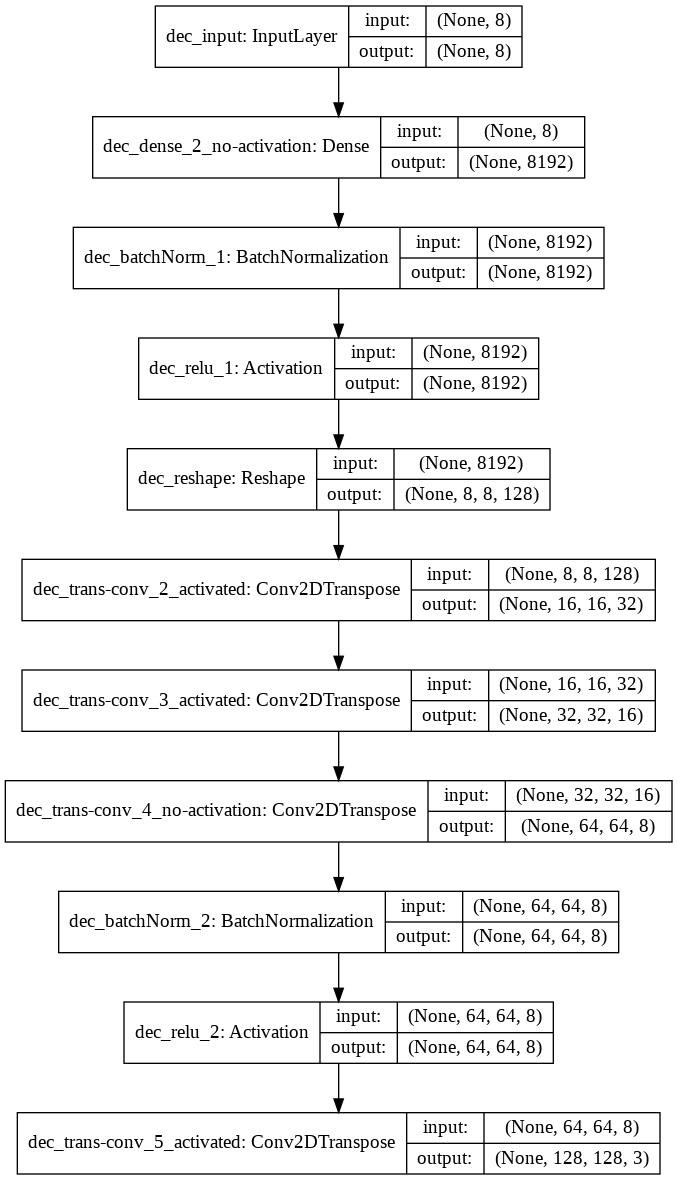

In [24]:
summarize(decoder_1)

### Decoder 2

In [25]:
# VAE decoder 2 - inception units
input_dec = Input(shape=(dec_dim,), name="dec_input")
h_d = Dense(dim_post_flatten, name="dec_dense_2_no-activation")(input_dec)
h_d = BatchNormalization(name="dec_batchNorm_1")(h_d)
h_d = Activation(activation="relu", name="dec_relu_1")(h_d)
h_d = Reshape(dim_pre_flatten,name="dec_reshape")(h_d)

## inception 1
inc1_1 = Conv2D(filters= 16, kernel_size=1, strides=1, padding='same', activation="relu")(h_d)
inc1_2 = Conv2D(filters= 16, kernel_size=3, strides=1, padding='same', activation="relu")(h_d)
h_d = concatenate([inc1_1,inc1_2])

h_d = Conv2DTranspose(filters= 32, kernel_size=3, strides=2, padding='same', activation="relu", name="dec_trans-conv_2_activated")(h_d)

## inception 2
inc2_1 = Conv2D(filters= 8, kernel_size=1, strides=1, padding='same', activation="relu")(h_d)
inc2_2 = Conv2D(filters= 8, kernel_size=3, strides=1, padding='same', activation="relu")(h_d)
h_d = concatenate([inc2_1,inc2_2])

h_d = Conv2DTranspose(filters= 16, kernel_size=3, strides=2, padding='same', activation="relu", name="dec_trans-conv_3_activated")(h_d)

## inception 3
inc3_1 = Conv2D(filters= 4, kernel_size=1, strides=1, padding='same', activation="relu")(h_d)
inc3_2 = Conv2D(filters= 4, kernel_size=3, strides=1, padding='same', activation="relu")(h_d)
h_d = concatenate([inc3_1,inc3_2])

h_d = Conv2DTranspose(filters= 8, kernel_size=3, strides=2, padding='same', name="dec_trans-conv_4_no-activation")(h_d)
h_d = BatchNormalization(name="dec_batchNorm_2")(h_d)
h_d = Activation(activation="relu", name="dec_relu_2")(h_d)

## inception 4
inc4_1 = Conv2D(filters= 2, kernel_size=1, strides=1, padding='same', activation="relu")(h_d)
inc4_2 = Conv2D(filters= 2, kernel_size=3, strides=1, padding='same', activation="relu")(h_d)
h_d = concatenate([inc4_1,inc4_2])

h_d = Conv2DTranspose(filters= colors, kernel_size=3, strides=2, padding='same', activation="sigmoid", name="dec_trans-conv_5_activated")(h_d) # the activation depends on the data normalization (sigmoid or tanh)

decoder_2 = Model(inputs=input_dec, outputs = h_d, name="decoder")

Model: "decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dec_input (InputLayer)          (None, 8)            0                                            
__________________________________________________________________________________________________
dec_dense_2_no-activation (Dens (None, 8192)         73728       dec_input[0][0]                  
__________________________________________________________________________________________________
dec_batchNorm_1 (BatchNormaliza (None, 8192)         32768       dec_dense_2_no-activation[0][0]  
__________________________________________________________________________________________________
dec_relu_1 (Activation)         (None, 8192)         0           dec_batchNorm_1[0][0]            
____________________________________________________________________________________________

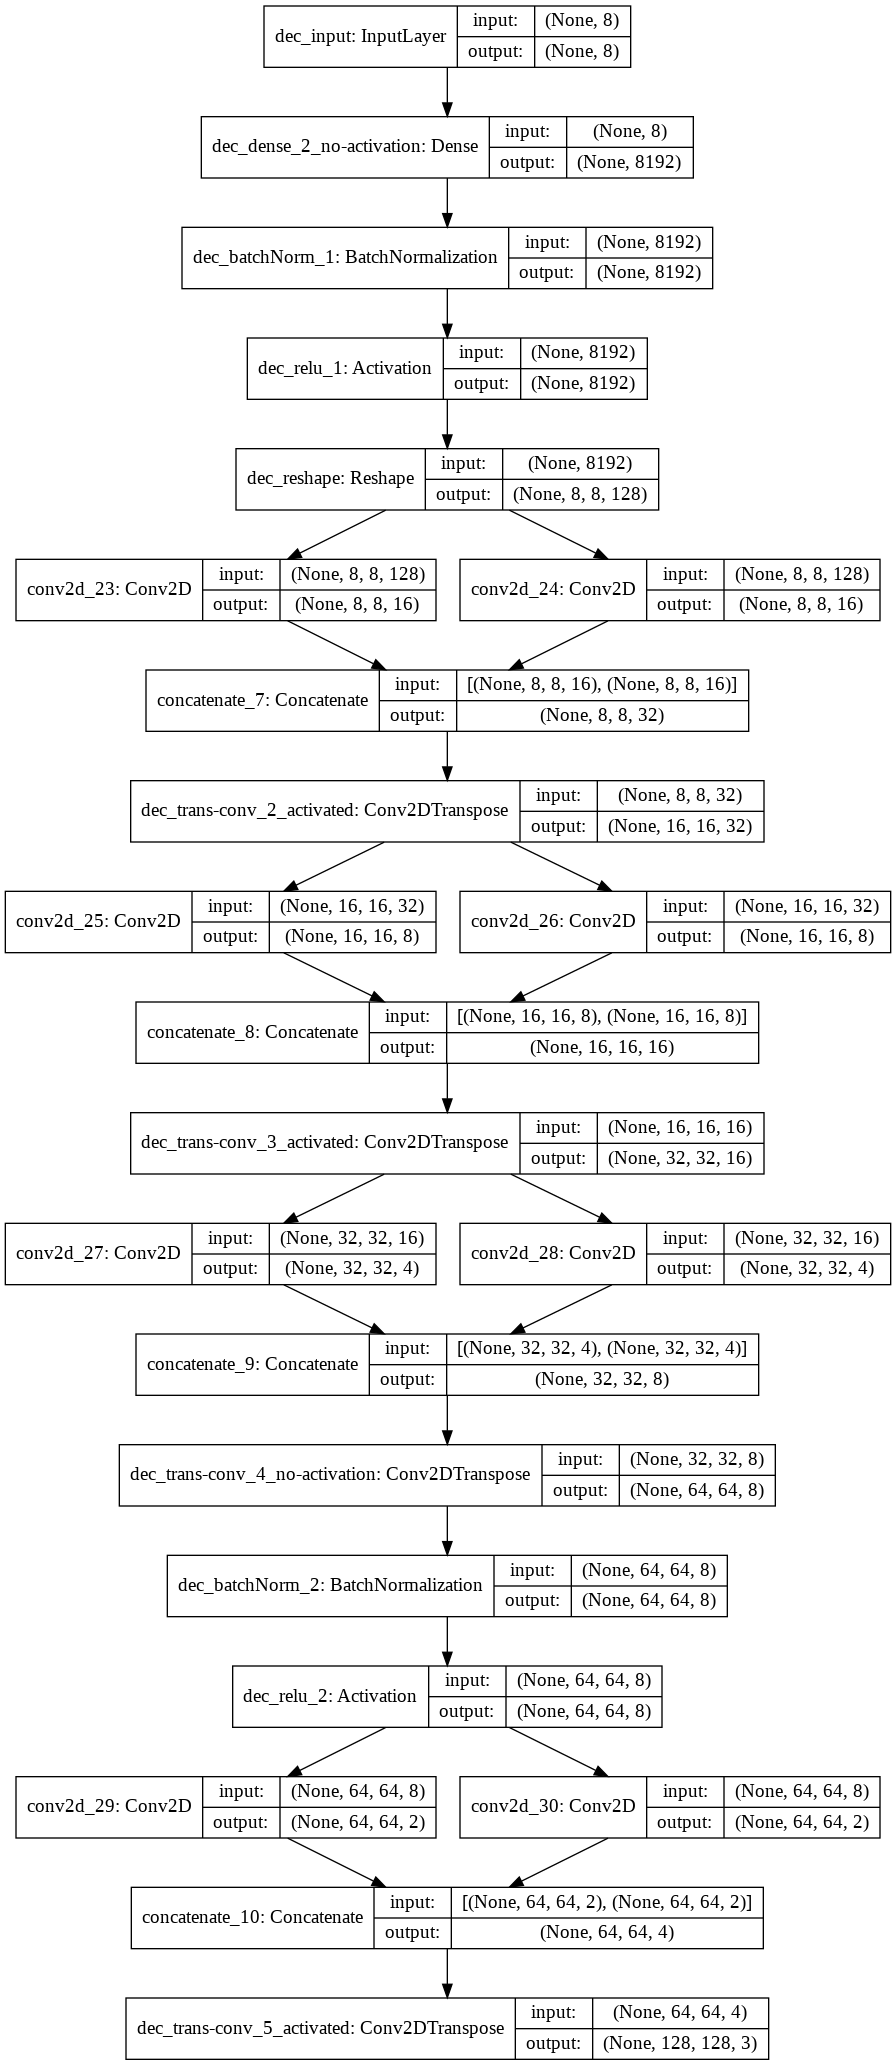

In [26]:
summarize(decoder_2)

### Decoder 3

In [27]:
# decoder 3 - Generator
noise = Input(shape=(dec_dim,), name="G_in")
# Dense 1
h = Dense(1024)(noise) 
h = BatchNormalization(momentum=0.99)(h) #0.8
h = Activation("relu")(h)
# Dense 2
h = Dense(7*7*128)(h)
h = BatchNormalization(momentum=0.99)(h)
h = Activation("relu")(h)
# Reshape
h = Reshape((7, 7, 128))(h)
# Conv 1
h = Conv2DTranspose(64, kernel_size=5, strides=2, padding="same")(h)
h = BatchNormalization(momentum=0.99)(h)
h = Activation("relu")(h)
# Conv 2
h = Conv2DTranspose(32, kernel_size=5, strides=2, padding="same")(h)
h = BatchNormalization(momentum=0.99)(h)
h = Activation("relu")(h)
# Conv to image
h = Conv2DTranspose(colors, kernel_size=1, strides=1, padding="same")(h)
G_out = Activation("sigmoid", name="G_out")(h)
decoder_3 = Model(noise,G_out,name="decoder")

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
G_in (InputLayer)            (None, 8)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              9216      
_________________________________________________________________
batch_normalization_15 (Batc (None, 1024)              4096      
_________________________________________________________________
activation_1 (Activation)    (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 6272)              6428800   
_________________________________________________________________
batch_normalization_16 (Batc (None, 6272)              25088     
_________________________________________________________________
activation_2 (Activation)    (None, 6272)              0   

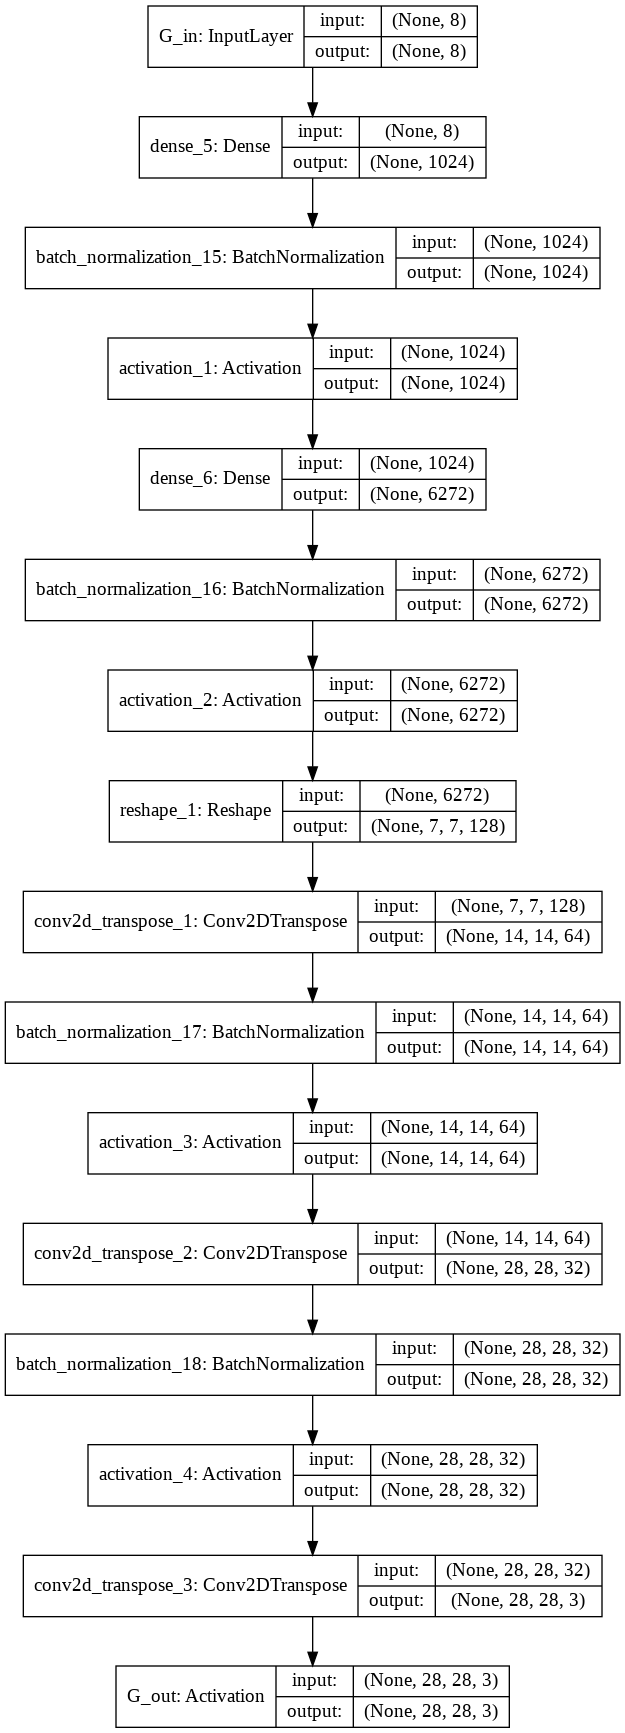

In [28]:
summarize(decoder_3)

### Decoder 4

In [29]:
# decoder 4 - Generator
noise = Input(shape=(dec_dim,), name="G_in")
## add labels
input_dec_labels = Input(shape=(labels_dim,), name="dec_input_labels")
h = concatenate([noise,input_dec_labels])
# Dense 1
h = Dense(1024)(h) 
h = BatchNormalization(momentum=0.99)(h) #0.8
h = Activation("relu")(h)
# Dense 2
h = Dense(dim_post_flatten)(h)
h = BatchNormalization(momentum=0.99)(h)
h = Activation("relu")(h)
# Reshape
h = Reshape(dim_pre_flatten)(h)
# Conv 1
h = Conv2DTranspose(64, kernel_size=filter_size, strides=2, padding="same")(h)
h = BatchNormalization(momentum=0.99)(h)
h = Activation("relu")(h)
# Conv 2
h = Conv2DTranspose(32, kernel_size=filter_size, strides=2, padding="same")(h)
h = BatchNormalization(momentum=0.99)(h)
h = Activation("relu")(h)
# Conv 3
h = Conv2DTranspose(16, kernel_size=filter_size, strides=2, padding="same")(h)
h = BatchNormalization(momentum=0.99)(h)
h = Activation("relu")(h)
# Conv to image
h = Conv2DTranspose(colors, kernel_size=1, strides=1, padding="same")(h)
G_out = Activation("sigmoid", name="G_out")(h)
decoder_4 = Model([noise,input_dec_labels],G_out,name="decoder")

### Summary

In [30]:
decoder = decoder_4

Model: "decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
G_in (InputLayer)               (None, 8)            0                                            
__________________________________________________________________________________________________
dec_input_labels (InputLayer)   (None, 3)            0                                            
__________________________________________________________________________________________________
concatenate_11 (Concatenate)    (None, 11)           0           G_in[0][0]                       
                                                                 dec_input_labels[0][0]           
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 1024)         12288       concatenate_11[0][0]       

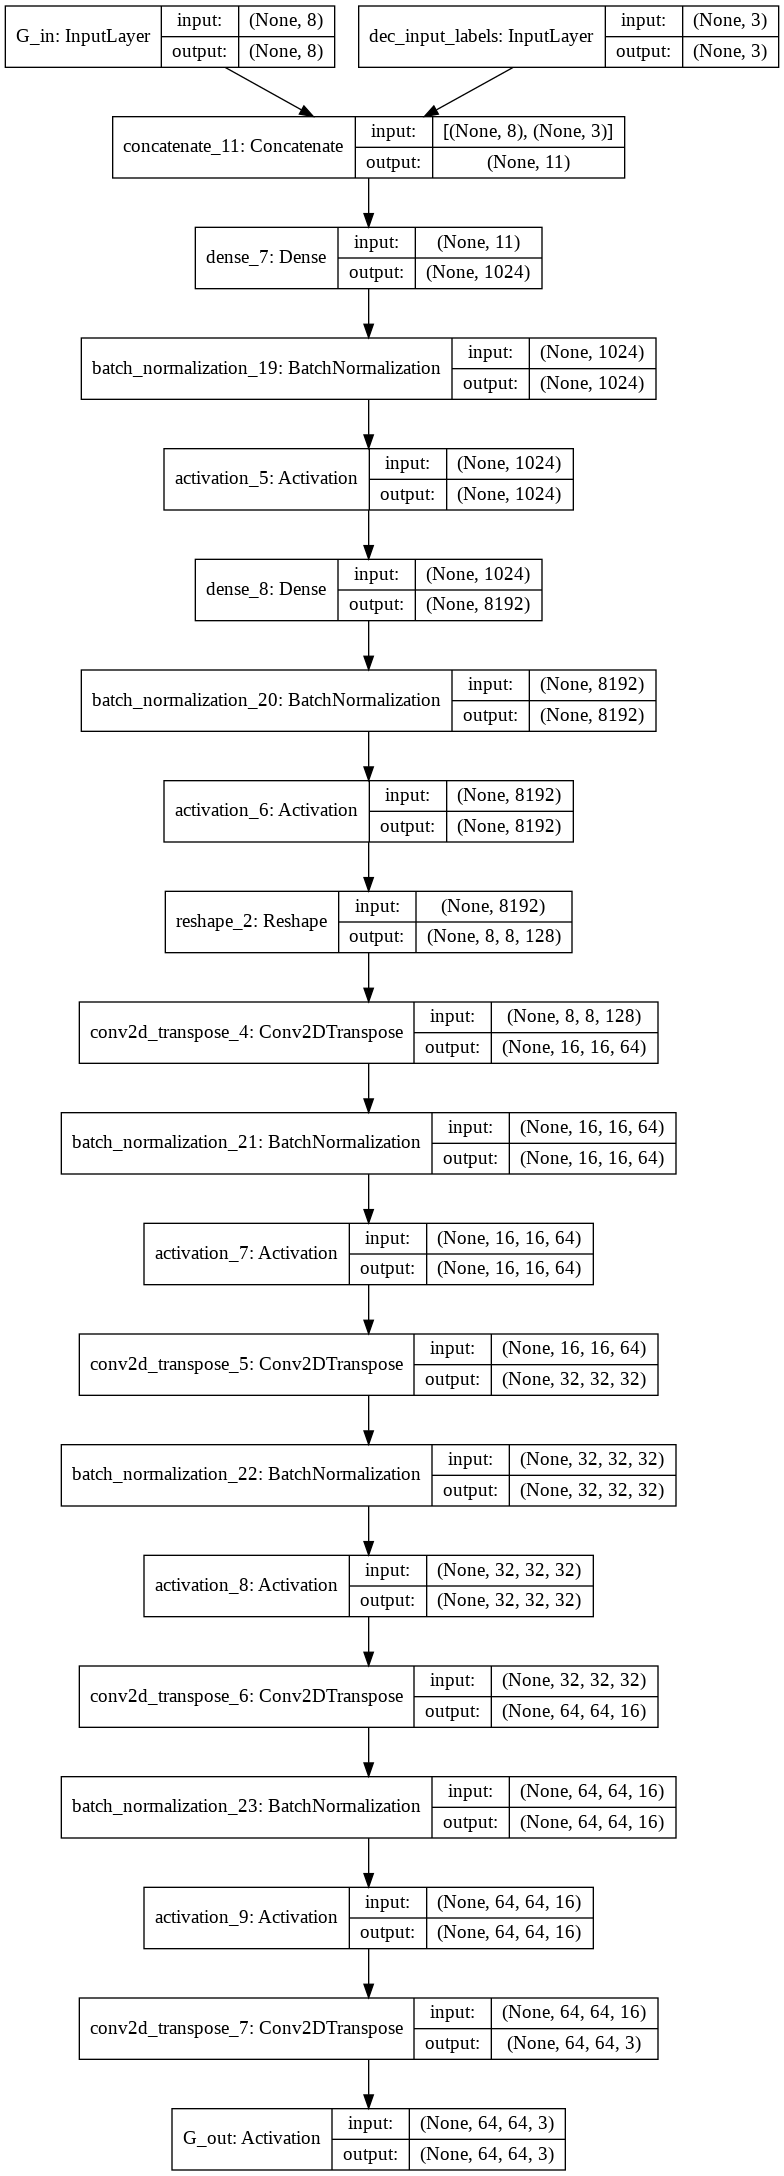

In [31]:
# summary of the decoder
decoder.summary()
# plot model
plot_model(decoder, to_file='decoder.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='decoder.png')

# Sampler

In [32]:
# sampling function
def gaussian_sampling(tensors):
    mu, sigma = tensors
    #batch_shape = mu.shape # this way does not work to extract shape of tensor
    # two ways to exrtact tensor shape
    batch = K.shape(mu)[0]
    dim = K.int_shape(mu)[1]
    return sigma*K.random_normal(shape=(batch, dim)) + mu
    #batch_shape = K.shape(mu)
    #return sigma*K.random_normal(shape=batch_shape) + mu

In [33]:
# sampling function
def gaussian_sampling_array(arrays):
    mu, sigma = arrays
    batch = mu.shape[0]
    dim = mu.shape[1]
    return sigma* np.random.normal(size=(batch, dim))+ mu
    #batch_shape = K.shape(mu)
    #return sigma*K.random_normal(shape=batch_shape) + mu

# Pipelines

## VAE

In [34]:

# VAE encoder + decoder
input_vae = Input(shape=(img_dim,img_dim,colors,), name="vae_input")
input_vae_labels = Input(shape=(labels_dim,), name="vae_input_labels")
z_latent = encoder([input_vae,input_vae_labels])
if ALPHA:
  sampling_layer = Lambda(gaussian_sampling,name="sample_Gaussian")
  z_sample = sampling_layer(z_latent)
  output_vae = decoder([z_sample,input_vae_labels])
else:
  output_vae = decoder([z_latent,input_vae_labels])
VAE = Model(inputs=[input_vae,input_vae_labels], outputs = output_vae)
#VAE = Model(inputs=input_vae, outputs = [output_vae,output_vae]) # two outputs to track two losses


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
vae_input (InputLayer)          (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
vae_input_labels (InputLayer)   (None, 3)            0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 8), (None, 8 8511152     vae_input[0][0]                  
                                                                 vae_input_labels[0][0]           
__________________________________________________________________________________________________
sample_Gaussian (Lambda)        (None, 8)            0           encoder[1][0]              

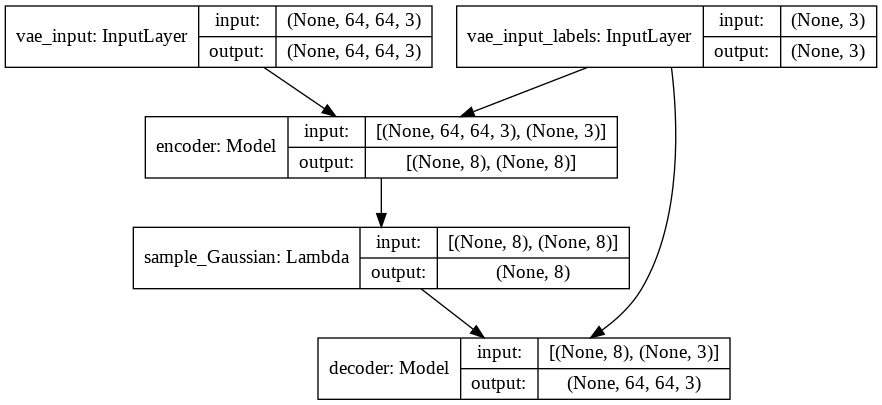

In [35]:
# summary of the complete VAE
VAE.summary()
# plot model
plot_model(VAE, to_file='VAE.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='VAE.png')

## Combined VAE-GAN

In [36]:
# Combined GAN: encoder + decoder + discriminator
input_GAN = Input(shape=(img_dim,img_dim,colors,), name="GAN_input")
input_GAN_labels = Input(shape=(labels_dim,), name="gan_input_labels")
z_latent = encoder([input_GAN,input_GAN_labels])
if ALPHA:
  sampling_layer = Lambda(gaussian_sampling,name="sample_Gaussian") 
  z_sample = sampling_layer(z_latent)
  output_vae = decoder([z_sample,input_GAN_labels])
else:
  output_vae = decoder([z_latent,input_GAN_labels])
          
# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
output_GAN = discriminator(output_vae)

# The combined model  (stacked generator and discriminator)
combined_GAN = Model([input_GAN,input_GAN_labels], output_GAN)

In [37]:
'''
# GAN only: decoder(generator) + discriminator
input_gen = Input(shape=(dec_dim,), name="gen_input")
input_gen_labels = Input(shape=(labels_dim,), name="gen_input_labels")
output_gen = decoder([input_gen,input_gen_labels])
          
# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
output_GAN_disc = discriminator(output_gen)

# The combined model  (stacked generator and discriminator)
GAN = Model([input_gen,input_gen_labels], output_GAN_disc)
'''

'\n# GAN only: decoder(generator) + discriminator\ninput_gen = Input(shape=(dec_dim,), name="gen_input")\ninput_gen_labels = Input(shape=(labels_dim,), name="gen_input_labels")\noutput_gen = decoder([input_gen,input_gen_labels])\n          \n# For the combined model we will only train the generator\ndiscriminator.trainable = False\n\n# The discriminator takes generated images as input and determines validity\noutput_GAN_disc = discriminator(output_gen)\n\n# The combined model  (stacked generator and discriminator)\nGAN = Model([input_gen,input_gen_labels], output_GAN_disc)\n'

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
GAN_input (InputLayer)          (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
gan_input_labels (InputLayer)   (None, 3)            0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 8), (None, 8 8511152     GAN_input[0][0]                  
                                                                 gan_input_labels[0][0]           
__________________________________________________________________________________________________
sample_Gaussian (Lambda)        (None, 8)            0           encoder[2][0]              

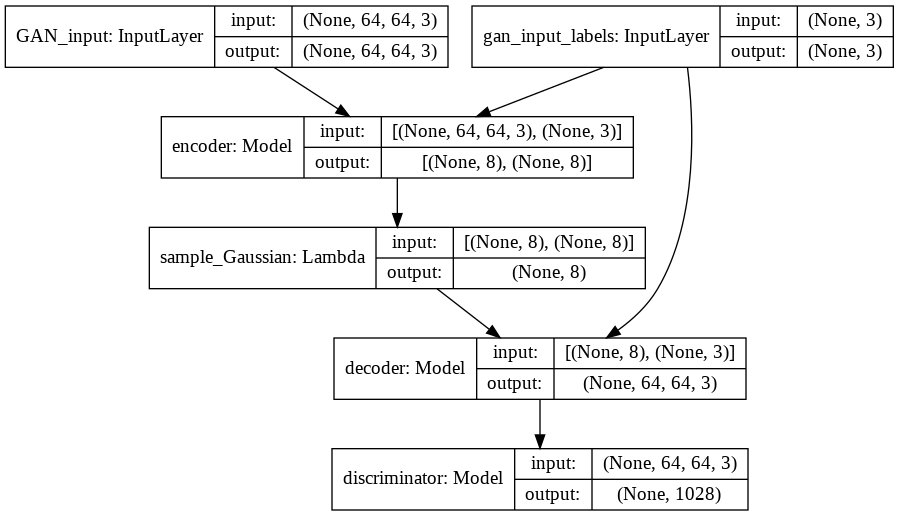

In [38]:
# summary of the combined GAN
combined_GAN.summary()
# plot model
plot_model(combined_GAN, to_file='combined_GAN.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='combined_GAN.png')

# Loss functions

In [39]:
## K = keras.Backend
## z_latent = [noise, labels]

# VAE loss
def my_vae_loss(y_true, y_pred):
    #reconstruction_loss = binary_crossentropy(K.flatten(y_true),K.flatten(y_pred))
    reconstruction_loss = mse(K.flatten(y_true), K.flatten(y_pred))
    reconstruction_loss *= img_dim * img_dim

    if ALPHA:
      #kl_loss = 1 + 2*K.log(z_std) - K.square(z_mu) - K.square(z_std) # this does NOT work (need to use the names as in the VAE)
      kl_loss = 1 + 2*K.log(z_latent[1]) - K.square(z_latent[0]) - K.square(z_latent[1])
      kl_loss = K.sum(kl_loss, axis=-1)
      kl_loss *= -0.5
      vae_loss = K.mean(reconstruction_loss + BETA*kl_loss)
    else:
      vae_loss = K.mean(reconstruction_loss)
    return vae_loss

def my_vae_loss_recon(y_true, y_pred):
    #reconstruction_loss = binary_crossentropy(K.flatten(y_true),K.flatten(y_pred))
    reconstruction_loss = mse(K.flatten(y_true), K.flatten(y_pred))

    reconstruction_loss *= img_dim * img_dim
    vae_loss = K.mean(reconstruction_loss)
    return vae_loss

def my_vae_loss_kl(y_true, y_pred):
    kl_loss = 1 + 2*K.log(z_latent[1]) - K.square(z_latent[0]) - K.square(z_latent[1])
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(kl_loss)
    return vae_loss

In [40]:
# GAN loss with mse and labels and learned metric, one output
def my_GAN_loss(y_true, y_pred):
    ## true/false
    adv_loss = binary_crossentropy(y_true[:,0],y_pred[:,0])
    ## labels
    class_loss = categorical_crossentropy(y_true[:,1:1+labels_dim],y_pred[:,1:1+labels_dim])
    ## image reconstruction
    reconstruction_loss = img_dim * img_dim * mse(K.flatten(input_GAN), K.flatten(output_vae))
    ## features
    learned_metric = mse(y_true[:,1+labels_dim:],y_pred[:,1+labels_dim:])


    if ALPHA:
      #kl_loss = 1 + 2*K.log(z_std) - K.square(z_mu) - K.square(z_std) # this does NOT work (need to use the names as in the VAE)
      kl_loss = 1 + 2*K.log(z_latent[1]) - K.square(z_latent[0]) - K.square(z_latent[1])
      kl_loss = K.sum(kl_loss, axis=-1)
      kl_loss *= -0.5
      GAN_loss = K.mean(adv_loss + ZETA*reconstruction_loss + BETA*kl_loss + DELTA*class_loss + GAMMA*learned_metric)
    else:
      GAN_loss = K.mean(adv_loss + ZETA*reconstruction_loss + DELTA*class_loss + GAMMA*learned_metric)
    return GAN_loss

In [41]:
# discriminator loss with labels, one output
def my_disc_loss(y_true, y_pred):
    adv_loss = binary_crossentropy(y_true[:,0],y_pred[:,0])
    class_loss = categorical_crossentropy(y_true[:,1:1+labels_dim],y_pred[:,1:1+labels_dim])
    disc_loss = K.mean(adv_loss + DELTA*class_loss)
    return disc_loss

# Compile

In [42]:

#VAE.compile(Adam(lr=0.02), loss=my_vae_loss)
#VAE.compile(Adam(), loss=my_vae_loss)
VAE.compile(optimizer = optimizer, loss=my_vae_loss)

#VAE.compile(Adam(lr=0.02), loss = [my_vae_loss_recon,my_vae_loss_kl], loss_weights = [1,BETA]) # two losses


In [43]:
combined_GAN.compile(optimizer = optimizer, loss=my_GAN_loss)

In [44]:
'''
GAN.compile(optimizer = optimizer, loss='binary_crossentropy')
'''

"\nGAN.compile(optimizer = optimizer, loss='binary_crossentropy')\n"

In [45]:
# compile discriminator with labels, one ouput
# second method, compile discriminator here after compiling combined GAN model and resetting trainable to true
discriminator.trainable = True
discriminator.compile(loss= my_disc_loss, optimizer= optimizer)

In [46]:
combined_GAN.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
GAN_input (InputLayer)          (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
gan_input_labels (InputLayer)   (None, 3)            0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 8), (None, 8 8511152     GAN_input[0][0]                  
                                                                 gan_input_labels[0][0]           
__________________________________________________________________________________________________
sample_Gaussian (Lambda)        (None, 8)            0           encoder[2][0]              

/tensorflow-1.15.2/python3.7/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [47]:
discriminator.summary()

Model: "discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
D_in (InputLayer)               (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
discriminator_metric (Model)    (None, 1024)         8491680     D_in[0][0]                       
__________________________________________________________________________________________________
D_out_adv (Dense)               (None, 1)            1025        discriminator_metric[1][0]       
__________________________________________________________________________________________________
D_out_labels (Dense)            (None, 3)            3075        discriminator_metric[1][0]       
______________________________________________________________________________________

# Dataset

In [48]:
# Mount google drive in the virtual machine
from google.colab import drive
drive.mount('/drive')


Mounted at /drive


In [49]:
x_train = np.load(root + 'galaxyzoo_data_cropped_nonnormalized.npy')
x_train = x_train/255.0

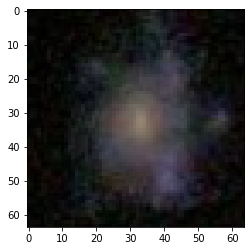

In [50]:
plt.imshow(x_train[8])

In [51]:
x_train.shape

(61578, 64, 64, 3)

In [52]:
import pandas as pd
df =  pd.read_csv(root + 'training_solutions_rev1.csv')
labels_train = np.array(df[df.columns[1:4]])

In [53]:
labels_train.shape

(61578, 3)

# Training

In [54]:
epochs=20
batch_size=128
save_interval=200
      
d_costs = []
g_costs = []

N = len(x_train)
n_batches = N // batch_size
total_iter = 0

# Adversarial ground truths
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

# make dir to save My_samples
if not os.path.exists(root_output):
  os.mkdir(root_output)

In [55]:
def save_imgs(iteration,gen_imgs):
        r, c = 8, 8
        #noise = np.random.normal(0, 1, (r * c, latent_dim))
        #gen_imgs = decoder.predict(noise)
        
        
        d = img_dim
        
        if gen_imgs.shape[-1] == 1:
            # if color == 1, we want a 2-D image (N x N)
            gen_imgs = gen_imgs.reshape(r*c, d, d)
            flat_image = np.empty((r*d, c*d))

            k = 0
            for i in range(8):
              for j in range(8):
                flat_image[i*d:(i+1)*d, j*d:(j+1)*d] = gen_imgs[k].reshape(d, d)
                k += 1

            
        else:
          # if color == 3, we want a 3-D image (N x N x 3)
          flat_image = np.empty((r*d, c*d, 3))
          k = 0
          for i in range(8):
            for j in range(8):
              flat_image[i*d:(i+1)*d, j*d:(j+1)*d] = gen_imgs[k]
              #flat_image[i*d:(i+1)*d, j*d:(j+1)*d] = (gen_imgs[k]+1)/2 # MD (not necessary, the png or jpg preview visualize both ranges the same way)
              k += 1
            
            
        # plt.savefig('samples/samples_at_iter_%d.png' % total_iters)
        #sp.misc.imsave('/content/drive/My Drive/Colab/VAE/images/samples_at_iter_%d.png' % iteration,flat_image)
        imageio.imwrite(root_output + f'samples_at_iter_{iteration}.png', flat_image)

In [56]:
# train GAN or combined GAN
for epoch in range(epochs):
        
      print("epoch:", epoch+1)
      #np.random.shuffle(x_train)
      idx = np.random.permutation(len(x_train))
      x_train = x_train[idx]
      labels_train = labels_train[idx]
        
      for j in range(n_batches):
        t0 = datetime.now()
      
      

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a batch of images
        imgs = x_train[j*batch_size:(j+1)*batch_size]

        labels = labels_train[j*batch_size:(j+1)*batch_size]
      
        # Sample noise and generate a batch of new images
        #noise = np.random.normal(0, 1, (batch_size, latent_dim))
        #gen_imgs = decoder.predict(noise)

        #noise_latent = encoder.predict(imgs)
        #if ALPHA:
          #gen_imgs = decoder.predict(gaussian_sampling_array(noise_latent))
        #else:
          #gen_imgs = decoder.predict(noise_latent)

        gen_imgs = VAE.predict([imgs,labels])
          

        # Train the discriminator (real classified as ones and generated as zeros)
        #d_loss_real = discriminator.train_on_batch(imgs, [valid,labels])
        #d_loss_fake = discriminator.train_on_batch(gen_imgs, [fake,labels])
        d_loss_real = discriminator.train_on_batch(imgs, np.concatenate((valid,labels),axis=1))
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.concatenate((fake,labels),axis=1))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        #d_loss = np.add(d_loss_real, d_loss_fake)
          
        d_costs.append(d_loss)
          

        # ---------------------
        #  Train Generator
        # ---------------------

        metric_real = discriminator_metric.predict(imgs)

        # Train the generator (wants discriminator to mistake images as real)
        #g_loss = combined_GAN.train_on_batch([imgs,labels], [valid,labels])

        set_trace()

        g_loss = combined_GAN.train_on_batch([imgs,labels], np.concatenate((valid,labels,metric_real),axis=1))


        #g_loss = GAN.train_on_batch(noise, valid)
          
        g_costs.append(g_loss)

        # Plot the progress
        #print ("Epoch %d - Batch: %d/%d [D loss: %f, acc.: %.2f%%] [G loss: %f] dt: %s " % (epoch+1,j+1,n_batches, d_loss[0], 100*d_loss[1], g_loss[0],datetime.now() - t0))
        print ("Epoch %d - Batch: %d/%d [D loss: %f] [G loss: %f] dt: %s " % (epoch+1,j+1,n_batches, d_loss, g_loss,datetime.now() - t0))
        total_iter += 1        
        # If at save interval => save generated image samples
        if total_iter  % save_interval == 0:
          save_imgs(total_iter,gen_imgs[:64])

# save a plot of the costs
plt.clf()
plt.plot(d_costs, label='discriminator cost')
plt.plot(g_costs, label='generator cost')
plt.legend()
plt.savefig(root_output + 'cost_vs_iteration.png')
plt.close()

# save models
#combined_GAN.save('/content/drive/My Drive/Colab/VAE/images_GAN/combined_GAN_model')
#VAE.save('/content/drive/My Drive/Colab/VAE/images_GAN/VAE_model')
#GAN.save('/content/drive/My Drive/Colab/VAE/images_GAN/GAN_model')

epoch: 1

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
> <ipython-input-56-a365b1e827ad>(59)<module>()
-> g_loss = combined_GAN.train_on_batch([imgs,labels], np.concatenate((valid,labels,metric_real),axis=1))
(Pdb) n


/tensorflow-1.15.2/python3.7/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


> <ipython-input-56-a365b1e827ad>(64)<module>()
-> g_costs.append(g_loss)
(Pdb) g_loss
314.50146
(Pdb) exit


BdbQuit: ignored

In [58]:
type(combined_GAN)

keras.engine.training.Model

In [ ]:
combined_GAN.save(root_output + 'combined_GAN_model')

In [ ]:
VAE.save(root_output + 'VAE_model')

In [ ]:
if ALPHA:
  label_loss = 'MSE+KL'
else:
  label_loss= 'MSE'
plt.plot(d_costs,label="Discriminator")
plt.plot(g_costs,label="Generator")
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.savefig(root_output + "cost_vs_iteration.png")
plt.show()
plt.close()


# Testing

In [ ]:
# plot original and reconstruced images from test set
i = np.random.choice(len(x_train))
print(i)
x = x_train[i]
y = labels_train[i]
print(x.shape)
x_hat = VAE.predict([x.reshape(-1,img_dim,img_dim,colors),y.reshape(-1,labels_dim)])
plt.figure(figsize=(6,8))
plt.subplot(1,2,1)
if colors ==3:
  plt.imshow(x)
else:
  plt.imshow(x.reshape(img_dim,img_dim), cmap='gray')
plt.grid(False)
plt.title("Original")
plt.subplot(1,2,2)
if colors ==3:
  plt.imshow(x_hat.reshape(img_dim,img_dim,colors))
else:
  plt.imshow(x_hat.reshape(img_dim,img_dim), cmap='gray')
plt.grid(False)
plt.title("Reconstruction")
plt.show()

In [ ]:
d = img_dim
res = 12
flat_image = np.empty((2*d, res*d, 3))
samples = np.random.choice(len(x_train),res)
print(samples)
for i in range(res):
  x = x_train[samples[i]]
  y = labels_train[samples[i]]
  x_hat = VAE.predict([x.reshape(-1,img_dim,img_dim,colors),y.reshape(-1,labels_dim)])
  flat_image[0*d:(0+1)*d, i*d:(i+1)*d] = x.reshape(img_dim,img_dim,colors)
  flat_image[1*d:(1+1)*d, i*d:(i+1)*d] = x_hat.reshape(img_dim,img_dim,colors)
plt.imshow(flat_image)
plt.grid(False)

In [ ]:
a = encoder.predict(x_train)

In [ ]:
a = np.asarray(a)

In [ ]:
a.shape

In [ ]:
x_ind = 6
y_ind = x_ind + 1

In [ ]:
m_x = a[0,:,x_ind]
#m_x = a[:,0]
m_y = a[0,:,y_ind]
#m_y = a[:,1]
plt.plot(m_x,m_y,'*',markersize=0.1)

In [ ]:
s_x = a[1,:,x_ind]
s_y = a[1,:,y_ind]
plt.plot(s_x,s_y,'*',markersize=0.1)

In [ ]:
latent_stat = np.zeros((latent_dim,4))
for i in range(latent_dim):
  latent_stat[i][0] = np.mean(a[0,:,i])
  latent_stat[i][1] = np.std(a[0,:,i])
  latent_stat[i][2] = np.max(a[0,:,i])
  latent_stat[i][3] = np.min(a[0,:,i])
#latent_stat

In [ ]:
latent_stat.shape

In [ ]:
d = 64
res = 8
flat_image = np.empty((res*d, res*d, 3))
x_ind = 6
y_ind = x_ind + 1
scale = 1
x_init = -3*scale
y_init = -3*scale
step_x = 2*abs(x_init)/(res-1)
step_y = 2*abs(y_init)/(res-1)
for i in range(res):
  for j in range(res):
    center_x = x_init +i*step_x
    center_y = y_init +j*step_y
    #random_latent = np.zeros((1,latent_dim))
    random_latent = np.array(latent_stat[:,0]).reshape(-1,latent_dim)
    random_latent[0,x_ind] = center_x
    random_latent[0,y_ind] = center_y
    random_sample = decoder.predict(random_latent)
    #random_sample = decoder.predict(np.array([latent_stat[0,0],latent_stat[1,0],center_x,center_y]).reshape(-1,latent_dim))
    random_sample.reshape(64,64,3)
    flat_image[i*d:(i+1)*d, j*d:(j+1)*d] = random_sample
plt.imshow(flat_image)
plt.grid(False)

In [ ]:
#cc = decoder.predict(np.array([1,1]).reshape(-1,2))


In [ ]:
x_enc = a[0,:,:]

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=latent_dim,svd_solver ="full")
pca.fit(x_enc)

In [ ]:
x_enc_trans = pca.transform(x_enc)
x_enc_hat = pca.inverse_transform(x_enc_trans)

In [ ]:
np.linalg.norm(x_enc - x_enc_hat)

In [ ]:
x_enc_trans.shape

In [ ]:
pca.explained_variance_ratio_

In [ ]:
pca.explained_variance_

In [ ]:
pca.singular_values_

In [ ]:
x_ind = 2
y_ind = x_ind + 1
m_x = x_enc_trans[:,x_ind]
#m_x = a[:,0]
m_y = x_enc_trans[:,y_ind]
#m_y = a[:,1]
plt.plot(m_x,m_y,'*',markersize=0.1)

In [ ]:
d = 64
res = 8
flat_image = np.empty((res*d, res*d, 3))
x_ind = 4
y_ind = x_ind + 1
scale = 1
x_init = -3*scale
y_init = -3*scale
step_x = 2*abs(x_init)/(res-1)
step_y = 2*abs(y_init)/(res-1)
for i in range(res):
  for j in range(res):
    center_x = x_init +i*step_x
    center_y = y_init +j*step_y
    random_latent = np.zeros((1,latent_dim))
    #random_latent = np.array(latent_stat[:,0]).reshape(-1,latent_dim)

    random_latent = pca.transform(random_latent)

    random_latent[0,x_ind] = center_x
    random_latent[0,y_ind] = center_y
    #random_sample = decoder.predict(random_latent)
    random_sample = decoder.predict(pca.inverse_transform(random_latent))
    random_sample.reshape(64,64,3)
    flat_image[i*d:(i+1)*d, j*d:(j+1)*d] = random_sample
plt.imshow(flat_image)
plt.grid(False)

## Interpolation

In [ ]:
from scipy.stats import norm

def lerp(val, low, high):
    """Linear interpolation"""
    return low + (high - low) * val

def lerp_gaussian(val, low, high):
    """Linear interpolation with gaussian CDF"""
    low_gau = norm.cdf(low)
    high_gau = norm.cdf(high)
    lerped_gau = lerp(val, low_gau, high_gau)
    return norm.ppf(lerped_gau)

def slerp(val, low, high):
    """Spherical interpolation. val has a range of 0 to 1."""
    if val <= 0:
        return low
    elif val >= 1:
        return high
    elif np.allclose(low, high):
        return low
    omega = np.arccos(np.dot(low/np.linalg.norm(low), high/np.linalg.norm(high)))
    so = np.sin(omega)
    return np.sin((1.0-val)*omega) / so * low + np.sin(val*omega)/so * high

def slerp_gaussian(val, low, high):
    """Spherical interpolation with gaussian CDF (generally not useful)"""
    offset = norm.cdf(np.zeros_like(low))  # offset is just [0.5, 0.5, ...]
    low_gau_shifted = norm.cdf(low) - offset
    high_gau_shifted = norm.cdf(high) - offset
    circle_lerped_gau = slerp(val, low_gau_shifted, high_gau_shifted)
    epsilon = 0.001
    clipped_sum = np.clip(circle_lerped_gau + offset, epsilon, 1.0 - epsilon)
    result = norm.ppf(clipped_sum)
    return result


In [ ]:
#id_1 = 0
#id_2 = 9
#id_1 = np.random.choice(len(x_train))
#id_2 = np.random.choice(len(x_train))
print(id_1,id_2)
x_1 = x_train[id_1]
x_2 = x_train[id_2]
plt.figure(figsize=(6,8))
plt.subplot(1,2,1)
plt.imshow(x_1)
plt.grid(False)
plt.title("First")
plt.subplot(1,2,2)
plt.imshow(x_2)
plt.grid(False)
plt.title("Second")
plt.show()

In [ ]:
## Interpolation in the latent space
d = 64
res = 10
flat_image = np.empty((4*d, res*d, 3))
latent_1 = x_enc[id_1]
latent_2 = x_enc[id_2]
plt.figure(figsize=(16,8))
for i in range(res):
  latent_interpolate_lin = lerp(i/(res-1), latent_1, latent_2)
  latent_interpolate_sph = slerp(i/(res-1), latent_1, latent_2)
  latent_interpolate_linG = lerp_gaussian(i/(res-1), latent_1, latent_2)
  latent_interpolate_sphG = slerp_gaussian(i/(res-1), latent_1, latent_2)
  sample_interpolate_lin = decoder.predict(latent_interpolate_lin.reshape(-1,latent_dim))
  sample_interpolate_sph = decoder.predict(latent_interpolate_sph.reshape(-1,latent_dim))
  sample_interpolate_linG = decoder.predict(latent_interpolate_linG.reshape(-1,latent_dim))
  sample_interpolate_sphG = decoder.predict(latent_interpolate_sphG.reshape(-1,latent_dim))
  flat_image[0*d:(0+1)*d, i*d:(i+1)*d] = sample_interpolate_lin.reshape(64,64,3)
  flat_image[1*d:(1+1)*d, i*d:(i+1)*d] = sample_interpolate_sph.reshape(64,64,3)
  flat_image[2*d:(2+1)*d, i*d:(i+1)*d] = sample_interpolate_linG.reshape(64,64,3)
  flat_image[3*d:(3+1)*d, i*d:(i+1)*d] = sample_interpolate_sphG.reshape(64,64,3)
plt.imshow(flat_image)
plt.grid(False)

In [ ]:
## Interpolation in the input space
d = 64
res = 10
flat_image = np.empty((4*d, res*d, 3))
x_1 = x_1.ravel()
x_2 = x_2.ravel()
# original 3d dim or faltten or ravel or reshape?? why the difference between all (because of the randomness in VAE not the diffrence in reshape funcitons)
plt.figure(figsize=(16,8))
for i in range(res):
  input_interpolate_lin = lerp(i/(res-1), x_1, x_2)
  input_interpolate_sph = slerp(i/(res-1), x_1, x_2)
  input_interpolate_linG = lerp_gaussian(i/(res-1), x_1, x_2)
  input_interpolate_sphG = slerp_gaussian(i/(res-1), x_1, x_2)
  sample_input_interpolate_lin = VAE.predict(input_interpolate_lin.reshape(-1,64,64,3))
  sample_input_interpolate_sph = VAE.predict(input_interpolate_sph.reshape(-1,64,64,3))
  sample_input_interpolate_linG = VAE.predict(input_interpolate_linG.reshape(-1,64,64,3))
  sample_input_interpolate_sphG = VAE.predict(input_interpolate_sphG.reshape(-1,64,64,3))
  flat_image[0*d:(0+1)*d, i*d:(i+1)*d] = sample_input_interpolate_lin.reshape(64,64,3)
  flat_image[1*d:(1+1)*d, i*d:(i+1)*d] = sample_input_interpolate_sph.reshape(64,64,3)
  flat_image[2*d:(2+1)*d, i*d:(i+1)*d] = sample_input_interpolate_linG.reshape(64,64,3)
  flat_image[3*d:(3+1)*d, i*d:(i+1)*d] = sample_input_interpolate_sphG.reshape(64,64,3)
plt.imshow(flat_image)
plt.grid(False)

In [ ]:
from sklearn.cluster import KMeans
n_clustres = 4
kmeans = KMeans(n_clusters=n_clustres, random_state=0).fit(x_enc)

In [ ]:
centroids = kmeans.cluster_centers_
centroids

In [ ]:
plt.plot(m_x,m_y,'*',markersize=0.1)
for center in centroids:
  plt.plot(center[0],center[1],'o', markersize=5)


In [ ]:
labels = kmeans.labels_
labels

In [ ]:
indices = list(np.arange(n_clustres))
for i in range(n_clustres):
  indices[i] = np.where(labels == i)

In [ ]:
indices

In [ ]:
# plot cluster images
cluster = 3
print("Cluster: ",cluster)
print(centroids[cluster])
samples = np.random.choice(np.asarray(indices[cluster]).ravel(),10)
print(samples)
for i, sample in enumerate(samples):
  x = x_train[sample]
  plt.subplot(2,5,i+1)
  plt.imshow(x)
  plt.grid(False)

In [ ]:
for i, sample in enumerate(samples):
  x = x_train[sample]
  x_hat = VAE.predict(x.reshape(-1,64,64,3))
  plt.subplot(2,5,i+1)
  plt.imshow(x_hat.reshape(64, 64,3))
  plt.grid(False)

In [ ]:
aa = np.random.choice(30,12)

In [ ]:
aa

In [ ]:
aa.reshape((1,2,2,3))

In [ ]:
aa_f = aa.flatten()
aa_f

In [ ]:
aa

In [ ]:
aa_r = aa.ravel()
aa_r

In [ ]:
aa

In [ ]:
x_1.shape

In [ ]:
x_1[0].shape

In [ ]:
K.image_data_format()